# Quick start to KinFragLib

Introduction on how to load and use the fragment library

In [1]:
import pandas as pd
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw

from util import read_fragment_library, most_common_fragments

### Access fragment library:

In [2]:
# Path to library folder
PATH_TO_LIB = Path('.') / '..' / 'data' / 'fragment_library'

In [3]:
fragment_library = read_fragment_library(PATH_TO_LIB)
fragment_library.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

*fragment_library* is a dictionary containing a pandas dataframe for each of the six subpockets (AP, FP, SE, GA, B1, B2) and the X pool.

For each fragment in each subpocket it contains the RDKit molecule object, the SMILES string, and the kinase group and PDB codes of the structure from which the fragment originated.

#### Access fragments in specific subpocket (here AP):

In [4]:
AP_fragments = fragment_library['AP']
AP_fragments.head()

,smiles,fragment,group,complex_pdb,ligand_pdb
0,Nc1c[nH]c2ncccc12,<rdkit.Chem.rdchem.Mol object at 0x7fb99d0faad0>,Other,5l4q,LKB
1,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7fb99d0faa80>,Other,5te0,XIN
2,Cc1cc(N)[nH]n1,<rdkit.Chem.rdchem.Mol object at 0x7fb99d0faa30>,TK,2f4j,VX6
3,Nc1ncc(C=O)s1,<rdkit.Chem.rdchem.Mol object at 0x7fb99d0fa9e0>,TK,2gqg,1N1
4,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,<rdkit.Chem.rdchem.Mol object at 0x7fb99d0fab20>,TK,2v7a,627


The fragments can either be loaded without dummy atoms (default; dummy atoms are replaced with hydrogens) or with dummy atoms.

#### Load fragments with dummy atoms:

In [5]:
fragment_library_dummy_atoms = read_fragment_library(PATH_TO_LIB, remove_dummy=False)

In [6]:
AP_fragments_dummy_atoms = fragment_library_dummy_atoms['AP']

#### Show fragments with and without dummy atoms next to each other:

In [7]:
AP_fragments_dummy_atoms = AP_fragments_dummy_atoms.rename(
    columns={"smiles": "smiles_dummy_atoms", "fragment": "fragment_dummy_atoms"})

In [8]:
pd.concat([AP_fragments, AP_fragments_dummy_atoms], axis=1, join='inner') \
            [['smiles', 'smiles_dummy_atoms']].head()

,smiles,smiles_dummy_atoms
0,Nc1c[nH]c2ncccc12,[11*]c1cnc2[nH]cc(N[27*])c2c1
1,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1
2,Cc1cc(N)[nH]n1,[22*]Nc1cc(C)n[nH]1
3,Nc1ncc(C=O)s1,[15*]Nc1ncc(C([41*])=O)s1
4,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12


### View all fragments of a specific inhibitor (here Gefitinib - IRE):

In [9]:
IRE_fragment_list = []

In [10]:
# find IRE fragments in each subpocket
for subpocket in fragment_library_dummy_atoms.keys():
    
    subpocket_fragments = fragment_library_dummy_atoms[subpocket]
    IRE_subpocket_fragments = subpocket_fragments[subpocket_fragments.ligand_pdb == 'IRE']
    
    IRE_subpocket_fragment_list = [frag.SetProp('subpocket', subpocket) for frag in 
                                   list(IRE_subpocket_fragments.fragment)]
    
    IRE_fragment_list.extend(list(IRE_subpocket_fragments.fragment))

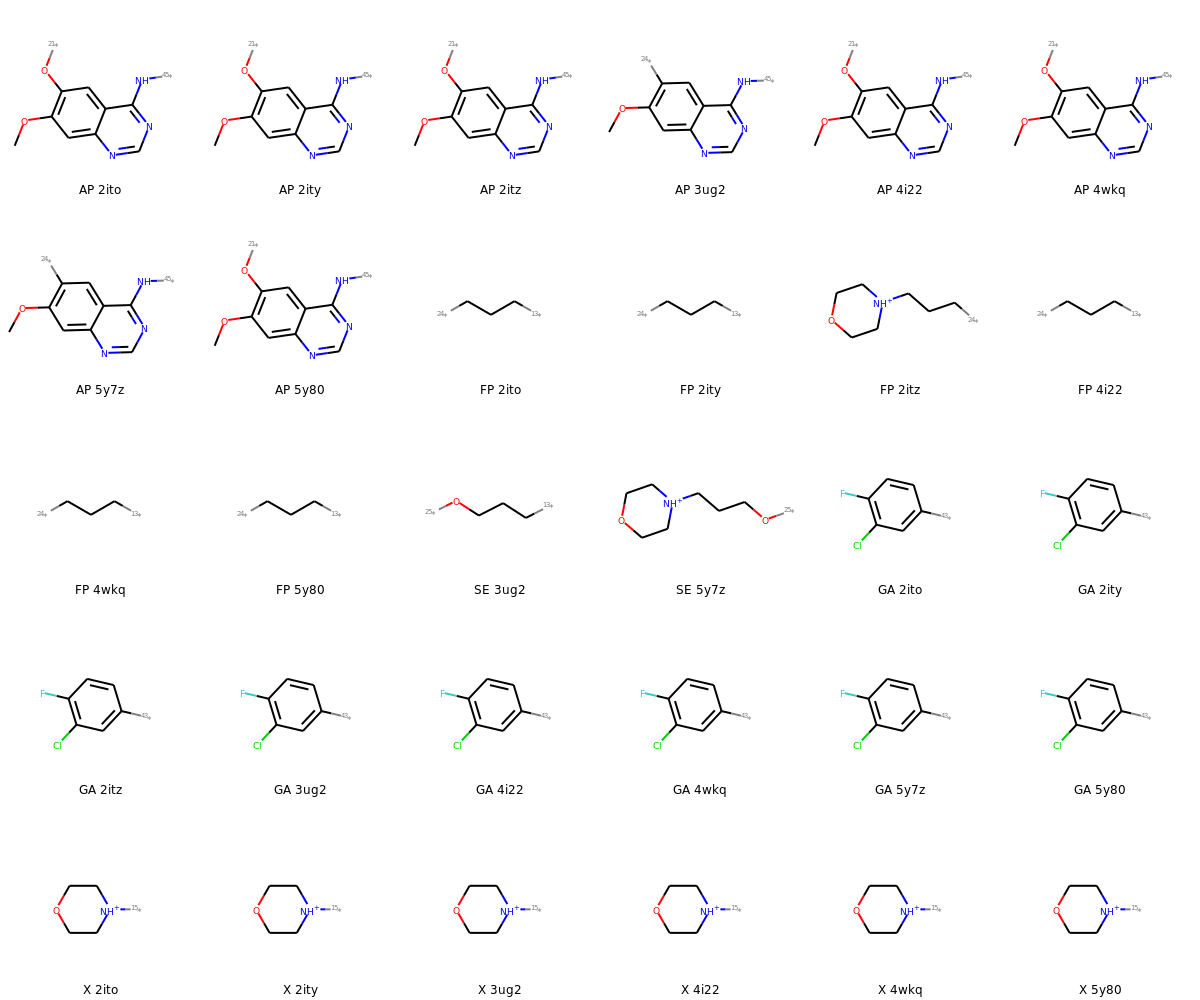

In [11]:
Draw.MolsToGridImage(IRE_fragment_list, 
                     legends=[frag.GetProp('subpocket')+' '+frag.GetProp('complex_pdb') for frag in IRE_fragment_list], 
                     molsPerRow=6)

### Identify most common fragments in a subpocket (here AP):

In [21]:
mols, mols_count = most_common_fragments(AP_fragments, top_x=25)

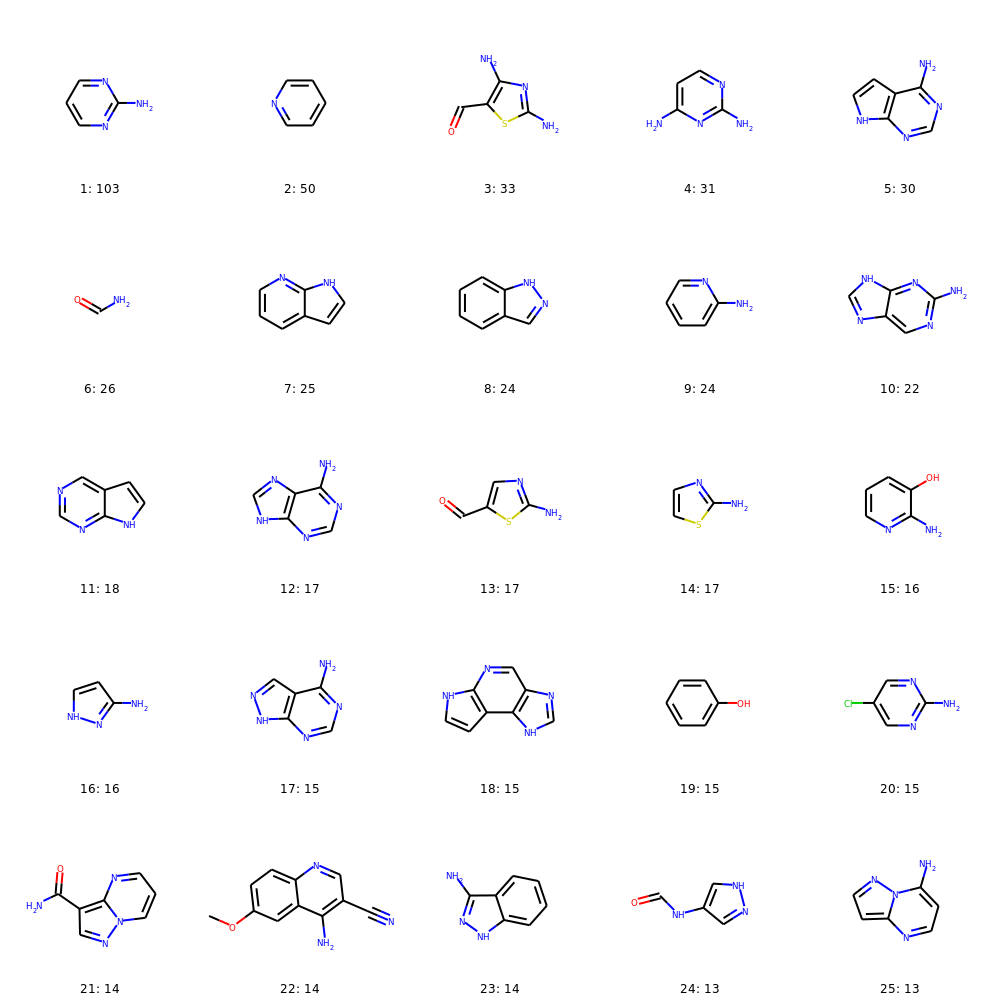

In [22]:
Draw.MolsToGridImage(mols, legends=[str(i+1)+': '+str(x) for i, x in enumerate(mols_count)], molsPerRow=5)